In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import muon as mu
from muon import prot as pt
import os
import h5py
from mudata import MuData
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_array
import anndata as ad

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/si

In [2]:
from sklearn.mixture import GaussianMixture  # different in updated sklearn (prev GMM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import rgb2hex

In [3]:
import milopy  # had to revert markupsafe (2.0.1) for updated version issue
import milopy.core as milo
import itertools
from distinctipy import distinctipy

In [4]:
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata

def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash_onoff'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash_onoff'][z])
            rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep

def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep


def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood


def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def plot_durable_clusters(adata, cluster_labels, title, alpha=0.1, beta=0.5, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] < alpha, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] > beta, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < -beta, "graph_color"] = np.nan

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

    return sc_louvain.astype('int')

In [5]:
rna_sing = sc.read('/Users/anasuyadighe/Downloads/cpi-cd40-main/Round4_celltypes_collapsed.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
all_d8 = []
unt_d8 = np.where(rna_sing.obs['sample'] == 'P1-TD-d8')[0]
trt_d8 = np.where(rna_sing.obs['sample'] == 'P2-T1-d8')[0]
adata = rna_sing[np.concatenate((unt_d8, trt_d8)), :]
all_d8.append(adata.copy())

In [7]:
concatenated_data = ad.concat(all_d8, join='outer')
concatenated_data

AnnData object with n_obs × n_vars = 4102 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    obsm: 'X_pca', 'X_umap', 'hash_onoff'

In [8]:
concatenated_data = remove_recompute(concatenated_data)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


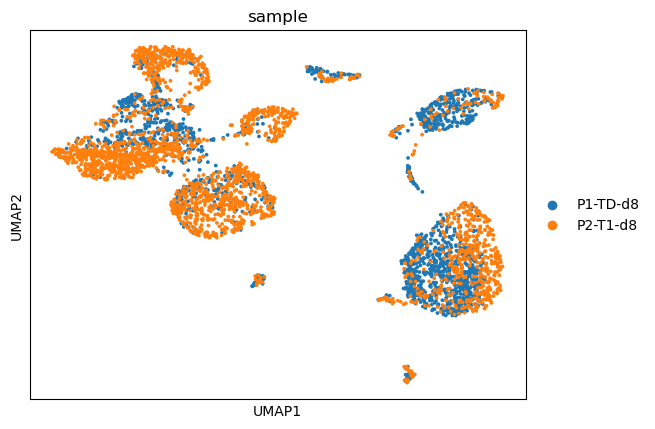

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


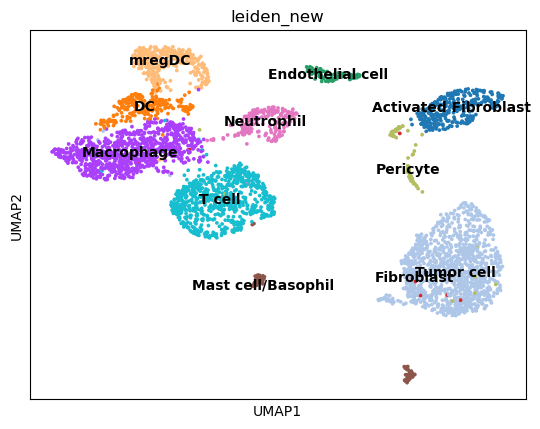

In [51]:
sc.pl.umap(concatenated_data, color = 'sample')
sc.pl.umap(concatenated_data, color = 'leiden_new', legend_loc = 'on data')

In [11]:
concatenated_data.obs['replicate'] = encode_replicates(concatenated_data, None)

In [13]:
time_dict = {'P1-TD-d8': 0,
             'P2-T1-d8': 100}
concatenated_data.obs['cond_continuous'] = concatenated_data.obs["sample"].map(time_dict).astype(int)

In [14]:
concatenated_data.obs['sample_rep'] = build_samplerep(concatenated_data, 'cond_continuous', 'replicate')

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_32487/1680834334.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


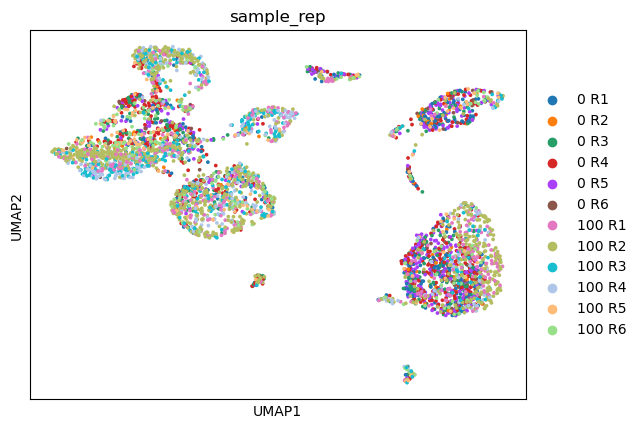

In [15]:
sc.pl.umap(concatenated_data, color='sample_rep')

In [16]:
concatenated_data.obs['rep_code'] = concatenated_data.obs['sample_rep'].cat.codes

In [17]:
milo.make_nhoods(concatenated_data, prop = 0.1)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[33.76895905 34.72622681 28.92601967 29.18101311 37.31115723 33.50115967
 32.151474   30.3963623  40.7125206  48.90732956 31.89441109 44.80737686
 34.84076309 46.25568008 79.49502563 53.05732727 30.77310944 36.91604614
 30.33239937 34.96552277 40.04103088 43.61194992 28.19900703 38.55165482
 33.59238434 35.65255737 37.69010162 33.40110397 32.29257965 38.8975029
 44.5477562  53.19598389 43.79602432 33.2154007  29.86412048 38.78020477
 39.71404266 43.02663803 43.8237381  31.99704742 28.63200378 49.57528687
 37.72938538 40.64015198 55.97281265 36.87012482 30.15119934 40.1043396
 50.90618896 32.33359528 39.48761749 36.46958923 30.63820076 44.64864731
 39.9891243  38.69451523 40.64788055 32.01995087 36.46664047 37.20101547
 34.35115433 33.41843796 39.39122391 35.51289368 69.42795563 33.

In [18]:
concatenated_data.obsm["nhoods"]

<4102x330 sparse matrix of type '<class 'numpy.float32'>'
	with 9470 stored elements in Compressed Sparse Row format>

In [19]:
concatenated_data[concatenated_data.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
AAACTGGGTATTCGAC-1-P1-TD-d8                  1           33.768959
AAAGTCATCTATCACG-1-P1-TD-d8                  1           34.726227
AAATGGTGTAAGGTTG-1-P1-TD-d8                  1           28.926020
AACACTAAGATAACGC-1-P1-TD-d8                  1           29.181013
AACCATAAGCTCATTG-1-P1-TD-d8                  1           37.311157
...                                        ...                 ...
TTGCGGTTCGATATTC-1-P2-T1-d8                  1           48.650852
TTGGCCAGTAATGCGA-1-P2-T1-d8                  1           29.033545
TTGGTCATCGCTCAGT-1-P2-T1-d8                  1           36.057331
TTTCAAGGTTGAGCTT-1-P2-T1-d8                  1           55.376637
TTTGGCGGTCAACAAG-1-P2-T1-d8                  1           22.858620

[330 rows x 2 columns]

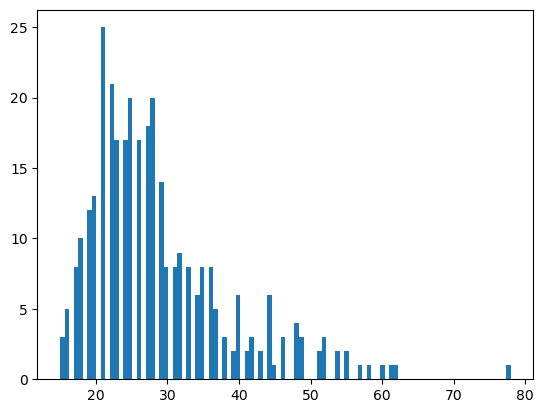

In [20]:
nhood_size = np.array(concatenated_data.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [21]:
milo.count_nhoods(concatenated_data, sample_col="rep_code")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [22]:
concatenated_data.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 330 × 12
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [23]:
milo.DA_nhoods(concatenated_data, design="~ cond_continuous")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:306: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:307: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [24]:
milo_results = concatenated_data.uns["nhood_adata"].obs

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


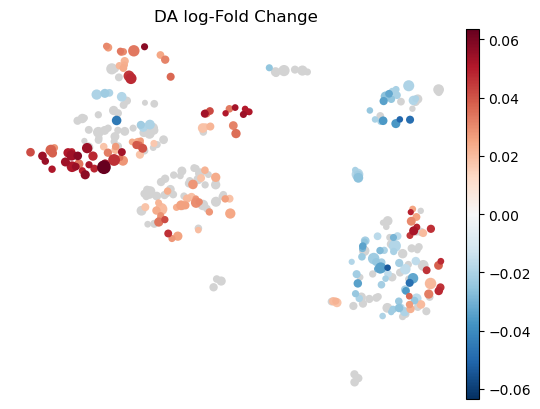

<Figure size 640x480 with 0 Axes>

In [25]:
milopy.utils.build_nhood_graph(concatenated_data)
milopy.plot.plot_nhood_graph(concatenated_data, alpha=0.1, min_size=5)
plt.tight_layout()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


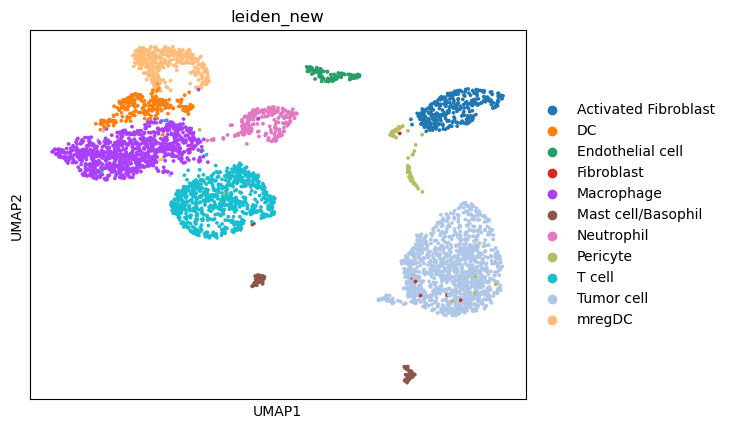

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


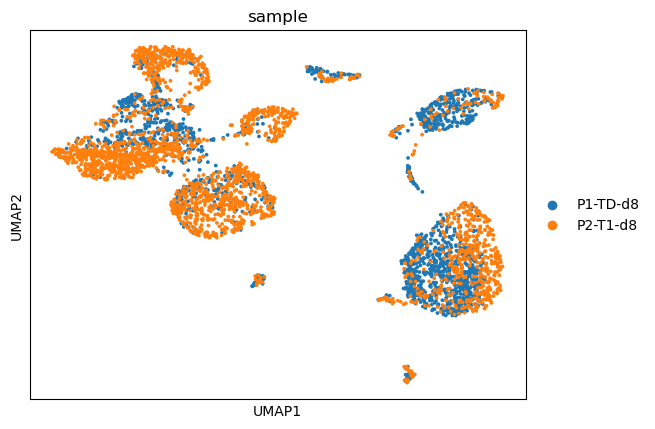

In [26]:
sc.pl.umap(concatenated_data, color = 'leiden_new')
sc.pl.umap(concatenated_data, color = 'sample')

In [27]:
milopy.utils.annotate_nhoods(concatenated_data, anno_col='leiden_new')

Text(0.5, 0, 'celltype fraction')

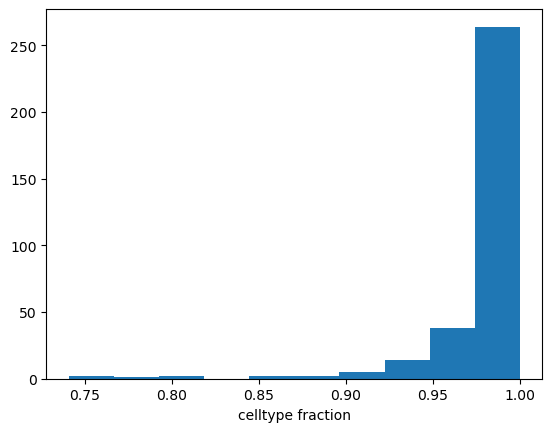

In [28]:
plt.hist(concatenated_data.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("celltype fraction")

In [29]:
celltype_dict = {'Activated Fibroblast': sns.color_palette('tab20', 20)[0],
                 'DC': sns.color_palette('tab20', 20)[2],
                 'Endothelial cell': sns.color_palette('tab20', 20)[4],
                 'Fibroblast': sns.color_palette('tab20', 20)[6],
                 'Macrophage': sns.color_palette('tab20', 20)[8],
                 'Mast cell/Basophil': sns.color_palette('tab20', 20)[9],
                 'Neutrophil': sns.color_palette('tab20', 20)[10],
                 'Pericyte': sns.color_palette('tab20', 20)[11],
                 'T cell': sns.color_palette('tab20', 20)[13],
                 'B cell': sns.color_palette('tab20', 20)[16],
                 'Tumor cell': sns.color_palette('tab20', 20)[17],
                 'mregDC': sns.color_palette('tab20', 20)[19]
               }

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


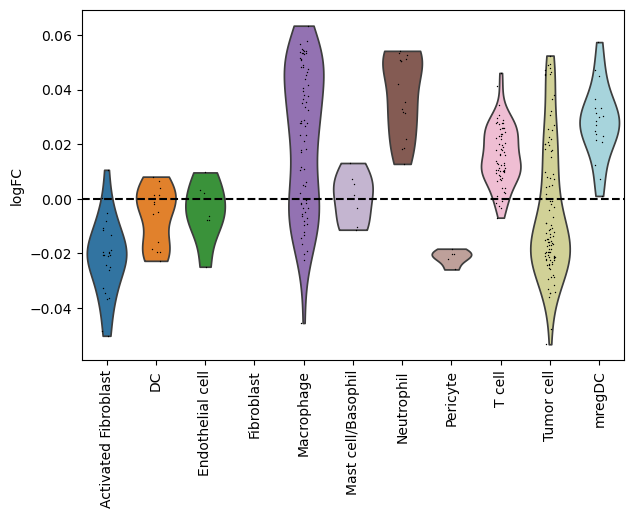

In [30]:
sc.pl.violin(concatenated_data.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False, palette=celltype_dict)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [31]:
concatenated_data.obs

sample  n_genes_by_counts  total_counts  \
AAACCAGGTCATGAAG-1-P1-TD-d8  P1-TD-d8                894        1619.0   
AAACGGGCAGTTATGG-1-P1-TD-d8  P1-TD-d8               1025        1729.0   
AAACTGGGTATTCGAC-1-P1-TD-d8  P1-TD-d8                573         796.0   
AAACTGGGTGCACTAT-1-P1-TD-d8  P1-TD-d8               1033        1870.0   
AAACTGGGTTACTCCC-1-P1-TD-d8  P1-TD-d8               1136        1590.0   
...                               ...                ...           ...   
TTTGCTCTCATCGATT-1-P2-T1-d8  P2-T1-d8                770        1504.0   
TTTGGCGGTACTTATG-1-P2-T1-d8  P2-T1-d8                863        1274.0   
TTTGGCGGTCAACAAG-1-P2-T1-d8  P2-T1-d8                386         517.0   
TTTGTGAGTCCACAAT-1-P2-T1-d8  P2-T1-d8               1331        2189.0   
TTTGTGAGTGTGAGTA-1-P2-T1-d8  P2-T1-d8                803        1197.0   

                             total_counts_mt  pct_counts_mt  n_counts hashing  \
AAACCAGGTCATGAAG-1-P1-TD-d8              5.0       0.308833    1619.0     1.0   
AAACGGGCAGTTATGG-1-P1-TD-d8             25.0       1.445922    1729.0     1.0   
AAACTGGGTATTCGAC-1-P1-TD-d8              2.0       0.251256     796.0     1.0   
AAACTGGGTGCACTAT-1-P1-TD-d8             26.0       1.390374    1870.0     1.0   
AAACTGGGTTACTCCC-1-P1-TD-d8              8.0       0.503145    1590.0     1.0   
...                                      ...            ...       ...     ...   
TTTGCTCTCATCGATT-1-P2-T1-d8              4.0       0.265957    1504.0     1.0   
TTTGGCGGTACTTATG-1-P2-T1-d8              0.0       0.000000    1274.0     1.0   
TTTGGCGGTCAACAAG-1-P2-T1-d8              2.0       0.386847     517.0     1.0   
TTTGTGAGTCCACAAT-1-P2-T1-d8              7.0       0.319781    2189.0     1.0   
TTTGTGAGTGTGAGTA-1-P2-T1-d8             18.0       1.503759    1197.0     1.0   

                            leiden hashtag   CD45 leiden_0.6  \
AAACCAGGTCATGAAG-1-P1-TD-d8      1  Hash 1  CD45+          1   
AAACGGGCAGTTATGG-1-P1-TD-d8      0  Hash 1  CD45-         12   
AAACTGGGTATTCGAC-1-P1-TD-d8      1  Hash 1  CD45+          1   
AAACTGGGTGCACTAT-1-P1-TD-d8      0  Hash 1  CD45-         12   
AAACTGGGTTACTCCC-1-P1-TD-d8      0  Hash 1  CD45-         10   
...                            ...     ...    ...        ...   
TTTGCTCTCATCGATT-1-P2-T1-d8      1  Hash 1  CD45+         14   
TTTGGCGGTACTTATG-1-P2-T1-d8      1  Hash 1  CD45+          1   
TTTGGCGGTCAACAAG-1-P2-T1-d8      1  Hash 1  CD45+          8   
TTTGTGAGTCCACAAT-1-P2-T1-d8      1  Hash 1  CD45+          4   
TTTGTGAGTGTGAGTA-1-P2-T1-d8      0  Hash 1  CD45-         10   

                                       leiden_new replicate  cond_continuous  \
AAACCAGGTCATGAAG-1-P1-TD-d8            Macrophage        R6                0   
AAACGGGCAGTTATGG-1-P1-TD-d8  Activated Fibroblast        R6                0   
AAACTGGGTATTCGAC-1-P1-TD-d8            Macrophage        R4                0   
AAACTGGGTGCACTAT-1-P1-TD-d8  Activated Fibroblast        R3                0   
AAACTGGGTTACTCCC-1-P1-TD-d8            Tumor cell        R4                0   
...                                           ...       ...              ...   
TTTGCTCTCATCGATT-1-P2-T1-d8            Neutrophil        R3              100   
TTTGGCGGTACTTATG-1-P2-T1-d8            Macrophage        R3              100   
TTTGGCGGTCAACAAG-1-P2-T1-d8                mregDC        R1              100   
TTTGTGAGTCCACAAT-1-P2-T1-d8            Macrophage        R1              100   
TTTGTGAGTGTGAGTA-1-P2-T1-d8            Tumor cell        R4              100   

                            sample_rep  rep_code  nhood_ixs_random  \
AAACCAGGTCATGAAG-1-P1-TD-d8       0 R6         5                 0   
AAACGGGCAGTTATGG-1-P1-TD-d8       0 R6         5                 0   
AAACTGGGTATTCGAC-1-P1-TD-d8       0 R4         3                 1   
AAACTGGGTGCACTAT-1-P1-TD-d8       0 R3         2                 0   
AAACTGGGTTACTCCC-1-P1-TD-d8       0 R4         3                 0   
...                

In [34]:
sc.tl.rank_genes_groups(concatenated_data, groupby='sample', key_added='group_DE_results')

In [36]:
concatenated_data.uns['group_DE_results']

{'params': {'groupby': 'sample',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Col3a1', 'Isg15'), ('Sparc', 'Irf7'), ('Col1a2', 'B2m'), ...,
            ('B2m', 'Col1a2'), ('Irf7', 'Sparc'), ('Isg15', 'Col3a1')],
           dtype=[('P1-TD-d8', 'O'), ('P2-T1-d8', 'O')]),
 'scores': rec.array([( 23.194784,  26.531137), ( 21.8967  ,  25.351013),
            ( 20.623255,  23.820612), ..., (-23.820612, -20.623255),
            (-25.351013, -21.8967  ), (-26.531137, -23.194784)],
           dtype=[('P1-TD-d8', '<f4'), ('P2-T1-d8', '<f4')]),
 'pvals': rec.array([(1.41669148e-110, 3.25228526e-143),
            (1.36142926e-099, 8.01650556e-132),
            (3.80835355e-089, 4.68894673e-117), ...,
            (4.68894673e-117, 3.80835355e-089),
            (8.01650556e-132, 1.36142926e-099),
            (3.25228526e-143, 1.41669148e-110)],
           dtype=[('P1-TD-d8', '<f8'), ('P2-T1-d8', '<f8'

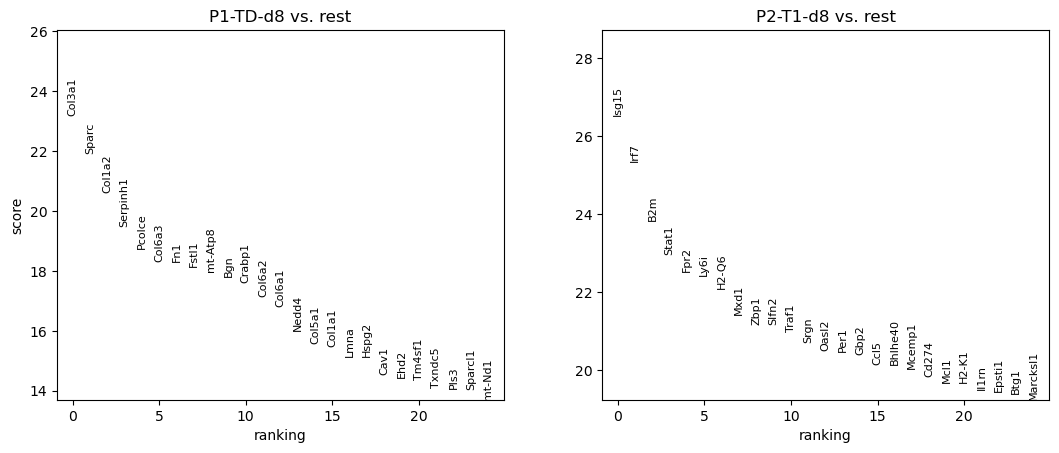

In [37]:
sc.pl.rank_genes_groups(concatenated_data, n_genes=25, sharey=False, key='group_DE_results')

In [39]:
mac = concatenated_data[concatenated_data.obs['leiden_new'].str.contains('Macrophage')]
mac

View of AnnData object with n_obs × n_vars = 875 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'replicate', 'cond_continuous', 'sample_rep', 'rep_code', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden_new_colors', 'sample_rep_colors', 'nhood_neighbors_key', 'nhood_adata', 'group_DE_results'
    obsm: 'hash_onoff', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [41]:
mac.obs

sample  n_genes_by_counts  total_counts  \
AAACCAGGTCATGAAG-1-P1-TD-d8  P1-TD-d8                894        1619.0   
AAACTGGGTATTCGAC-1-P1-TD-d8  P1-TD-d8                573         796.0   
AAACTGTCACAACATG-1-P1-TD-d8  P1-TD-d8                439         553.0   
AAAGATGCAAGAACAA-1-P1-TD-d8  P1-TD-d8                681         990.0   
AAAGTCATCTATCACG-1-P1-TD-d8  P1-TD-d8                479         587.0   
...                               ...                ...           ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8  P2-T1-d8                981        1539.0   
TTTGAGAAGTACCCAC-1-P2-T1-d8  P2-T1-d8               2568        5617.0   
TTTGCGGGTCAAGCTT-1-P2-T1-d8  P2-T1-d8               1437        2490.0   
TTTGGCGGTACTTATG-1-P2-T1-d8  P2-T1-d8                863        1274.0   
TTTGTGAGTCCACAAT-1-P2-T1-d8  P2-T1-d8               1331        2189.0   

                             total_counts_mt  pct_counts_mt  n_counts hashing  \
AAACCAGGTCATGAAG-1-P1-TD-d8              5.0       0.308833    1619.0     1.0   
AAACTGGGTATTCGAC-1-P1-TD-d8              2.0       0.251256     796.0     1.0   
AAACTGTCACAACATG-1-P1-TD-d8              1.0       0.180832     553.0     1.0   
AAAGATGCAAGAACAA-1-P1-TD-d8              5.0       0.505050     990.0     1.0   
AAAGTCATCTATCACG-1-P1-TD-d8              4.0       0.681431     587.0     1.0   
...                                      ...            ...       ...     ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8             27.0       1.754386    1539.0     1.0   
TTTGAGAAGTACCCAC-1-P2-T1-d8             50.0       0.890155    5617.0     1.0   
TTTGCGGGTCAAGCTT-1-P2-T1-d8             14.0       0.562249    2490.0     1.0   
TTTGGCGGTACTTATG-1-P2-T1-d8              0.0       0.000000    1274.0     1.0   
TTTGTGAGTCCACAAT-1-P2-T1-d8              7.0       0.319781    2189.0     1.0   

                            leiden hashtag   CD45 leiden_0.6  leiden_new  \
AAACCAGGTCATGAAG-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAACTGGGTATTCGAC-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAACTGTCACAACATG-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAAGATGCAAGAACAA-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAAGTCATCTATCACG-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
...                            ...     ...    ...        ...         ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8      1  Hash 1  CD45+          4  Macrophage   
TTTGAGAAGTACCCAC-1-P2-T1-d8      1  Hash 1  CD45+          2  Macrophage   
TTTGCGGGTCAAGCTT-1-P2-T1-d8      1  Hash 1  CD45+          4  Macrophage   
TTTGGCGGTACTTATG-1-P2-T1-d8      1  Hash 1  CD45+          1  Macrophage   
TTTGTGAGTCCACAAT-1-P2-T1-d8      1  Hash 1  CD45+          4  Macrophage   

                            replicate  cond_continuous sample_rep  rep_code  \
AAACCAGGTCATGAAG-1-P1-TD-d8        R6                0       0 R6         5   
AAACTGGGTATTCGAC-1-P1-TD-d8        R4                0       0 R4         3   
AAACTGTCACAACATG-1-P1-TD-d8        R1                0       0 R1         0   
AAAGATGCAAGAACAA-1-P1-TD-d8        R3                0       0 R3         2   
AAAGTCATCTATCACG-1-P1-TD-d8        R1                0       0 R1         0   
...                               ...              ...        ...       ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8        R2              100     100 R2         7   
TTTGAGAAGTACCCAC-1-P2-T1-d8        R6              100     100 R6        11   
TTTGCGGGTCAAGCTT-1-P2-T1-d8        R2              100     100 R2         7   
TTTGGCGGTACTTATG-1-P2-T1-d8        R3              100     100 R3         8   
TTTGTGAGTCCACAAT-1-P2-T1-d8        R1              100     100 R1         6   

                             nhood_ixs_random  nhood_ixs_refined  \
AAACCAGGTCATGAAG-1-P1-TD-d8                 0                  0   
AAACTGGGTATTCGAC-1-P1-TD-d8                 1                  1   
AAACTGTCACAACATG-1-P1-TD-d8                 0                  0   
AAAGATGCAAGAACAA-1-P1-TD-d8        

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


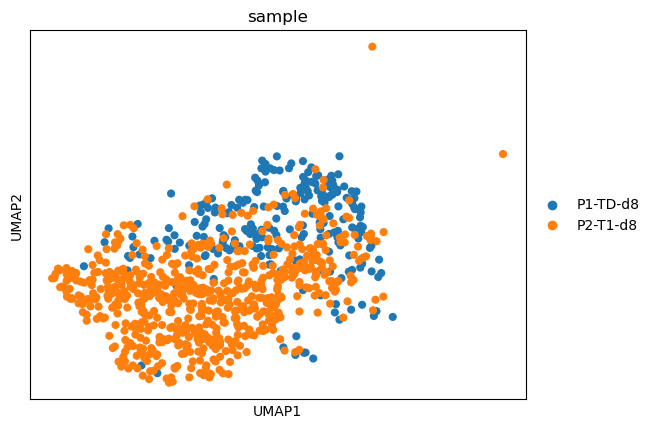

In [42]:
sc.pl.umap(mac, color = 'sample')

In [43]:
mac.obs['sample'].value_counts()

sample
P2-T1-d8    647
P1-TD-d8    228
Name: count, dtype: int64

In [45]:
mac

View of AnnData object with n_obs × n_vars = 875 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'replicate', 'cond_continuous', 'sample_rep', 'rep_code', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden_new_colors', 'sample_rep_colors', 'nhood_neighbors_key', 'nhood_adata', 'group_DE_results'
    obsm: 'hash_onoff', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


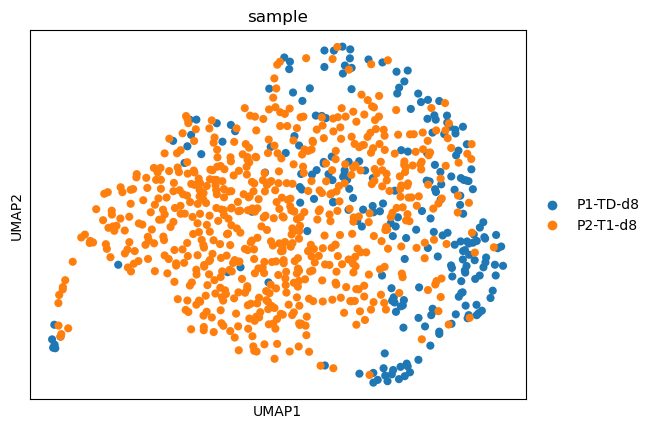

In [46]:
del mac.uns, mac.obsm, mac.varm, mac.obsp
sc.tl.pca(mac, svd_solver='arpack')
sc.pp.neighbors(mac, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(mac)
sc.pl.umap(mac, color='sample')

In [47]:
sc.tl.rank_genes_groups(mac, groupby='sample', key_added='mac_DE_results')

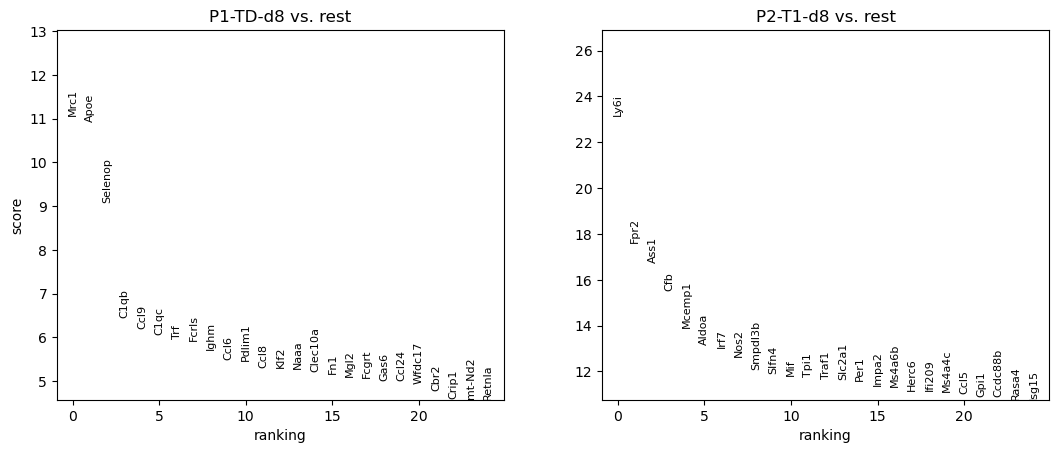

In [48]:
mac.uns['mac_DE_results']
sc.pl.rank_genes_groups(mac, n_genes=25, sharey=False, key='mac_DE_results')

In [50]:
mac.uns['mac_DE_results']

{'params': {'groupby': 'sample',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Mrc1', 'Ly6i'), ('Apoe', 'Fpr2'), ('Selenop', 'Ass1'), ...,
            ('Ass1', 'Selenop'), ('Fpr2', 'Apoe'), ('Ly6i', 'Mrc1')],
           dtype=[('P1-TD-d8', 'O'), ('P2-T1-d8', 'O')]),
 'scores': rec.array([( 11.07561 ,  23.1738  ), ( 10.938454,  17.604223),
            (  9.074298,  16.737854), ..., (-16.737854,  -9.074298),
            (-17.604223, -10.938454), (-23.1738  , -11.07561 )],
           dtype=[('P1-TD-d8', '<f4'), ('P2-T1-d8', '<f4')]),
 'pvals': rec.array([(4.84040290e-24, 1.33707576e-88),
            (2.23420763e-24, 1.96956334e-56),
            (1.39005454e-17, 1.44340112e-48), ...,
            (1.44340112e-48, 1.39005454e-17),
            (1.96956334e-56, 2.23420763e-24),
            (1.33707576e-88, 4.84040290e-24)],
           dtype=[('P1-TD-d8', '<f8'), ('P2-T1-d8', '<f8')]),
 'pvals_adj

In [54]:
def write_deres(excel_path, adata, group, de_key):
    # writing results to excel file
    res_cat = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']

    with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
        for g in np.unique(mac.obs[group]):
            d = {res_cat[0]: adata.uns[de_key][res_cat[0]][str(g)].tolist(),
                 res_cat[1]: adata.uns[de_key][res_cat[1]][str(g)].tolist(),
                 res_cat[2]: adata.uns[de_key][res_cat[2]][str(g)].tolist(),
                 res_cat[3]: adata.uns[de_key][res_cat[3]][str(g)].tolist(),
                 res_cat[4]: adata.uns[de_key][res_cat[4]][str(g)].tolist()
                 }
            df = pd.DataFrame(data=d)
            df.to_excel(writer, sheet_name=str(g))


In [55]:
file_dir = '/Users/anasuyadighe/Downloads/'
write_deres(file_dir + 'GAP_flex_day8_mac_sample_DEGs.xlsx', mac, 'sample', 'mac_DE_results')

In [67]:
unt_d8_mac_res = pd.read_csv('/Users/anasuyadighe/Downloads/gProfiler_d8_mac_unt_up_005.csv')
trt_d8_mac_res = pd.read_csv('/Users/anasuyadighe/Downloads/gProfiler_d8_mac_treated_up_005.csv')

In [68]:
mac_oi = ['WP:WP200', 'WP:WP1496','KEGG:04062', 'KEGG:04610', 'KEGG:04668','KEGG:05235']

In [58]:
def generate_heatmap(all_res, terms_oi):
    gsea_scores = np.zeros((len(terms_oi), len(all_res)))

    for f in range(len(all_res)):
        for g in range(len(terms_oi)):
            term_ind = np.where(all_res[f]['term_id'].str.contains(terms_oi[g]))
            if len(term_ind[0]) > 0:
                gsea_scores[g, f] = all_res[f]['negative_log10_of_adjusted_p_value'][term_ind[0]]

    return gsea_scores

In [69]:
mac_res = [unt_d8_mac_res, trt_d8_mac_res]

In [72]:
mac_scores = generate_heatmap(mac_res, mac_oi)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_32487/864201859.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gsea_scores[g, f] = all_res[f]['negative_log10_of_adjusted_p_value'][term_ind[0]]
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_32487/864201859.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gsea_scores[g, f] = all_res[f]['negative_log10_of_adjusted_p_value'][term_ind[0]]
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_32487/864201859.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gsea_scores[g, f] = all_res[f]['negative_log10_of_adjusted_p_value'][term_ind[0]]
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_32487/864201859.p

In [73]:
mac_scores

array([[2.57306334, 0.        ],
       [2.83182541, 0.        ],
       [1.54235787, 3.56080489],
       [1.73601534, 0.        ],
       [0.        , 4.49821596],
       [0.        , 3.995756  ]])

In [75]:
import matplotlib

In [76]:
cmap = matplotlib.cm.get_cmap("YlGnBu")
cmap.set_under("lightgray")

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_32487/3620925042.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("YlGnBu")


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


[None, None, None, None]

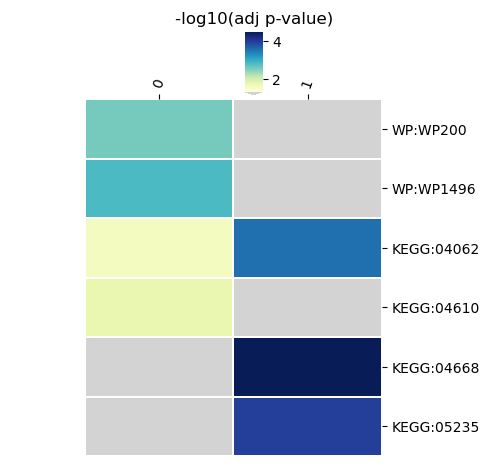

In [79]:
cg_ = sns.clustermap(mac_scores, cmap=cmap, xticklabels=[0, 1],
                     yticklabels=mac_oi, figsize=(5, 5),
                     cbar_kws={"shrink": 0.5, "extend": "min"}, linewidths=0.05, col_cluster=False, row_cluster=False,
                     vmin=-np.log10(0.05), square=True)  #, linecolor='black')

cg_.cax.set_title("-log10(adj p-value)")
cg_.cax.set_position([0.5, 0.8, 0.035, 0.125])
cg_.ax_heatmap.xaxis.tick_top()
cg_.ax_heatmap.xaxis.set_label_position('top')
plt.setp(cg_.ax_heatmap.xaxis.get_majorticklabels(), rotation=70)

In [80]:
mregDC = concatenated_data[concatenated_data.obs['leiden_new'].str.contains('mregDC')]
mregDC

View of AnnData object with n_obs × n_vars = 346 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'replicate', 'cond_continuous', 'sample_rep', 'rep_code', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
    uns: 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden_new_colors', 'sample_rep_colors', 'nhood_neighbors_key', 'nhood_adata', 'group_DE_results'
    obsm: 'hash_onoff', 'X_pca', 'X_umap', 'nhoods'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


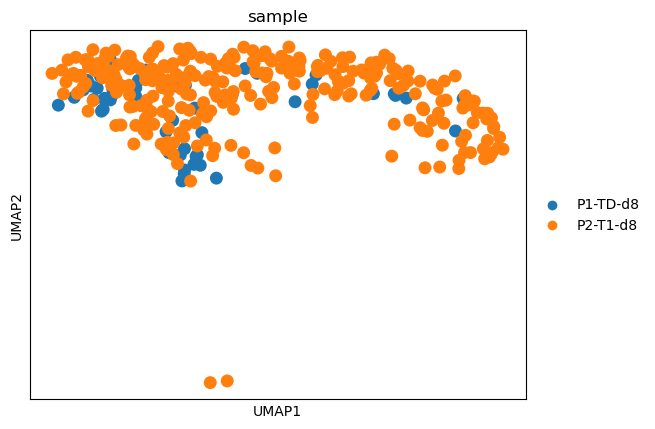

In [82]:
sc.pl.umap(mregDC, color = 'sample')

In [84]:
concatenated_data.obs['leiden_new']

AAACCAGGTCATGAAG-1-P1-TD-d8              Macrophage
AAACGGGCAGTTATGG-1-P1-TD-d8    Activated Fibroblast
AAACTGGGTATTCGAC-1-P1-TD-d8              Macrophage
AAACTGGGTGCACTAT-1-P1-TD-d8    Activated Fibroblast
AAACTGGGTTACTCCC-1-P1-TD-d8              Tumor cell
                                       ...         
TTTGCTCTCATCGATT-1-P2-T1-d8              Neutrophil
TTTGGCGGTACTTATG-1-P2-T1-d8              Macrophage
TTTGGCGGTCAACAAG-1-P2-T1-d8                  mregDC
TTTGTGAGTCCACAAT-1-P2-T1-d8              Macrophage
TTTGTGAGTGTGAGTA-1-P2-T1-d8              Tumor cell
Name: leiden_new, Length: 4102, dtype: category
Categories (11, object): ['Activated Fibroblast', 'DC', 'Endothelial cell', 'Fibroblast', ..., 'Pericyte', 'T cell', 'Tumor cell', 'mregDC']

In [85]:
T_nk = sc.read('/Users/anasuyadighe/Downloads/cpi-cd40-main/day8_CD4_CD8_and_NK_cells.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [86]:
T_nk.obs

sample  n_genes_by_counts  total_counts  \
AAACTGTCAGCTCGCT-1-P1-TD-d8  P1-TD-d8                469         589.0   
AAAGTCATCCATTAAC-1-P1-TD-d8  P1-TD-d8                621         779.0   
AAATCCTTCGCTCAGT-1-P1-TD-d8  P1-TD-d8                444         557.0   
AACCCGGCATCCGTCA-1-P1-TD-d8  P1-TD-d8                543         768.0   
AACCTAAAGGATTAGC-1-P1-TD-d8  P1-TD-d8                502         641.0   
...                               ...                ...           ...   
TTTCATCGTATTGACC-1-P2-T1-d8  P2-T1-d8                948        1575.0   
TTTCATCGTGTGAGGT-1-P2-T1-d8  P2-T1-d8                409         549.0   
TTTGCGCAGATAACTG-1-P2-T1-d8  P2-T1-d8                610         794.0   
TTTGCTCTCACGGACA-1-P2-T1-d8  P2-T1-d8               1914        3171.0   
TTTGCTCTCATAATCC-1-P2-T1-d8  P2-T1-d8                576         752.0   

                             total_counts_mt  pct_counts_mt  n_counts hashing  \
AAACTGTCAGCTCGCT-1-P1-TD-d8              1.0       0.169779     589.0     1.0   
AAAGTCATCCATTAAC-1-P1-TD-d8             10.0       1.283697     779.0     1.0   
AAATCCTTCGCTCAGT-1-P1-TD-d8              0.0       0.000000     557.0     1.0   
AACCCGGCATCCGTCA-1-P1-TD-d8              3.0       0.390625     768.0     1.0   
AACCTAAAGGATTAGC-1-P1-TD-d8             24.0       3.744150     641.0     1.0   
...                                      ...            ...       ...     ...   
TTTCATCGTATTGACC-1-P2-T1-d8              2.0       0.126984    1575.0     1.0   
TTTCATCGTGTGAGGT-1-P2-T1-d8              2.0       0.364299     549.0     1.0   
TTTGCGCAGATAACTG-1-P2-T1-d8              3.0       0.377834     794.0     1.0   
TTTGCTCTCACGGACA-1-P2-T1-d8              6.0       0.189215    3171.0     1.0   
TTTGCTCTCATAATCC-1-P2-T1-d8             19.0       2.526596     752.0     1.0   

                            leiden hashtag   CD45 leiden_0.6 leiden_new  \
AAACTGTCAGCTCGCT-1-P1-TD-d8      1  Hash 1  CD45+          5     T cell   
AAAGTCATCCATTAAC-1-P1-TD-d8      1  Hash 1  CD45+          5     T cell   
AAATCCTTCGCTCAGT-1-P1-TD-d8      1  Hash 1  CD45+          6     T cell   
AACCCGGCATCCGTCA-1-P1-TD-d8      1  Hash 1  CD45+          0     T cell   
AACCTAAAGGATTAGC-1-P1-TD-d8      1  Hash 1  CD45+          3     T cell   
...                            ...     ...    ...        ...        ...   
TTTCATCGTATTGACC-1-P2-T1-d8      1  Hash 1  CD45+          4     T cell   
TTTCATCGTGTGAGGT-1-P2-T1-d8      1  Hash 1  CD45+          0     T cell   
TTTGCGCAGATAACTG-1-P2-T1-d8      1  Hash 1  CD45+          0     T cell   
TTTGCTCTCACGGACA-1-P2-T1-d8      1  Hash 1  CD45+          5     T cell   
TTTGCTCTCATAATCC-1-P2-T1-d8      1  Hash 1  CD45+          5     T cell   

                                         nn_80 leiden_0.4 leiden_TNK  
AAACTGTCAGCTCGCT-1-P1-TD-d8  Poorly classified          2        CD4  
AAAGTCATCCATTAAC-1-P1-TD-d8         CD8 T cell          4         NK  
AAATCCTTCGCTCAGT-1-P1-TD-d8                 NK          4         NK  
AACCCGGCATCCGTCA-1-P1-TD-d8         CD8 T cell          0        CD8  
AACCTAAAGGATTAGC-1-P1-TD-d8  Poorly classified          2        CD4  
...                                        ...        ...        ...  
TTTCATCGTATTGACC-1-P2-T1-d8                 NK          5         NK  
TTTCATCGTGTGAGGT-1-P2-T1-d8  Poorly classified          0        CD8  
TTTGCGCAGATAACTG-1-P2-T1-d8         CD8 T cell          0        CD8  
TTTGCTCTCACGGACA-1-P2-T1-d8         CD8 T cell          2        CD4  
TTTGCTCTCATAATCC-1-P2-T1-d8                 NK          4         NK  

[732 rows x 15 columns]

In [88]:
T_nk.obs['leiden_TNK'].value_counts()

leiden_TNK
CD4    298
NK     220
CD8    214
Name: count, dtype: int64

In [90]:
cd4_d8 = T_nk[T_nk.obs['leiden_TNK'].str.contains('CD4')]
cd4_d8


View of AnnData object with n_obs × n_vars = 298 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new', 'nn_80', 'leiden_0.4', 'leiden_TNK'
    uns: 'leiden_TNK_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


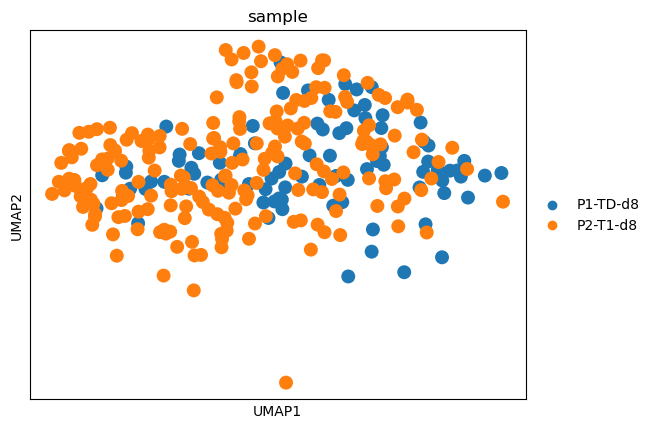

sample
P2-T1-d8    210
P1-TD-d8     88
Name: count, dtype: int64

In [91]:
cd4_d8.obs
sc.pl.umap(cd4_d8, color = 'sample')
cd4_d8.obs['sample'].value_counts()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


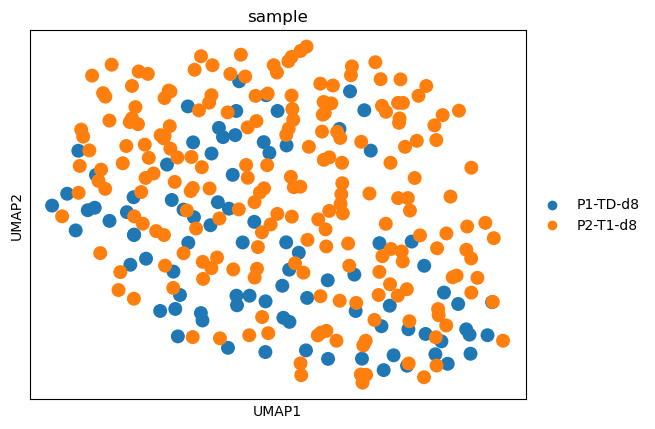

In [92]:
del cd4_d8.uns, cd4_d8.obsm, cd4_d8.varm, cd4_d8.obsp
sc.tl.pca(cd4_d8, svd_solver='arpack')
sc.pp.neighbors(cd4_d8, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(cd4_d8)
sc.pl.umap(cd4_d8, color='sample')

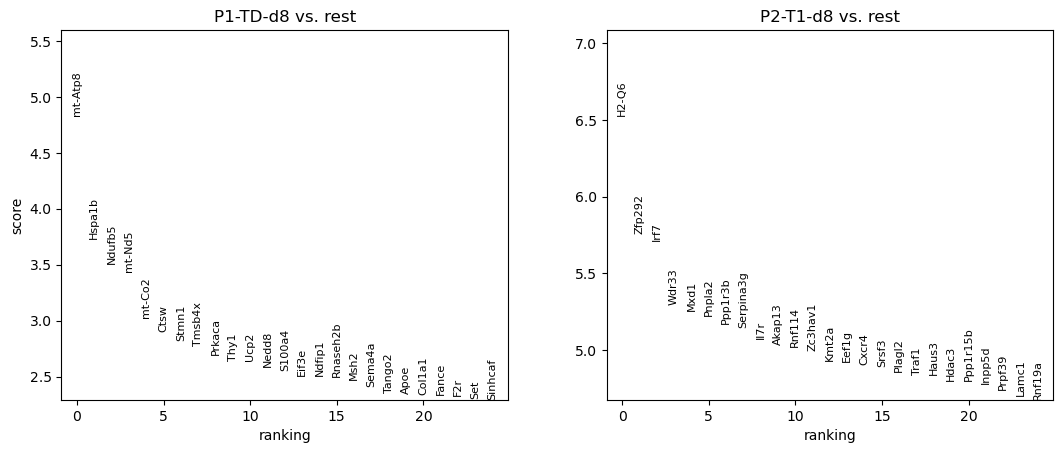

In [93]:
sc.tl.rank_genes_groups(cd4_d8, groupby='sample', key_added='cd4_d8_DE_results')
cd4_d8.uns['cd4_d8_DE_results']
sc.pl.rank_genes_groups(cd4_d8, n_genes=25, sharey=False, key='cd4_d8_DE_results')

In [103]:
file_dir = '/Users/anasuyadighe/Downloads/'
write_deres(file_dir + 'GAP_flex_day8_cd4_d8_sample_DEGs.xlsx', cd4_d8, 'sample', 'cd4_d8_DE_results')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


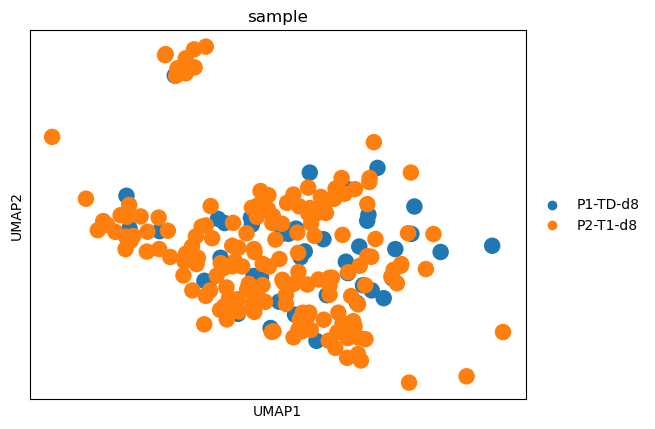

sample
P2-T1-d8    168
P1-TD-d8     46
Name: count, dtype: int64

In [95]:
cd8_d8 = T_nk[T_nk.obs['leiden_TNK'].str.contains('CD8')]
cd8_d8
cd8_d8.obs
sc.pl.umap(cd8_d8, color = 'sample')
cd8_d8.obs['sample'].value_counts()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


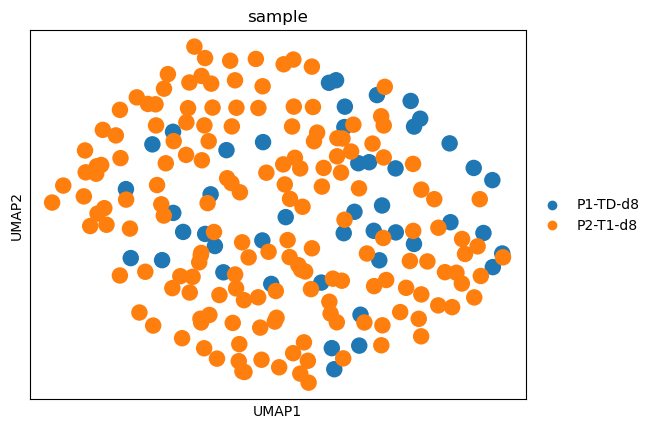

In [96]:
del cd8_d8.uns, cd8_d8.obsm, cd8_d8.varm, cd8_d8.obsp
sc.tl.pca(cd8_d8, svd_solver='arpack')
sc.pp.neighbors(cd8_d8, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(cd8_d8)
sc.pl.umap(cd8_d8, color='sample')

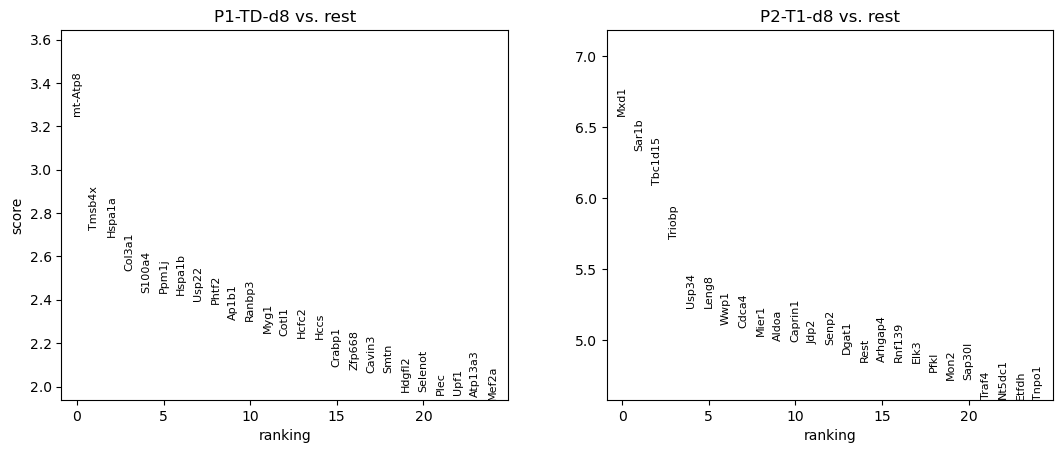

In [97]:
sc.tl.rank_genes_groups(cd8_d8, groupby='sample', key_added='cd8_d8_DE_results')
cd8_d8.uns['cd8_d8_DE_results']
sc.pl.rank_genes_groups(cd8_d8, n_genes=25, sharey=False, key='cd8_d8_DE_results')

In [98]:
file_dir = '/Users/anasuyadighe/Downloads/'
write_deres(file_dir + 'GAP_flex_day8_cd8_d8_sample_DEGs.xlsx', cd8_d8, 'sample', 'cd8_d8_DE_results')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


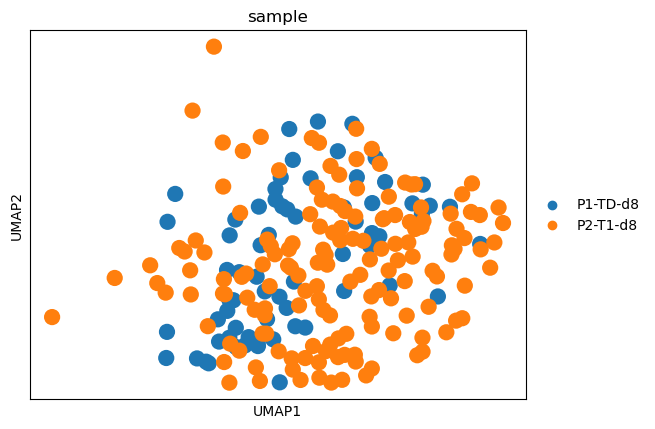

sample
P2-T1-d8    153
P1-TD-d8     67
Name: count, dtype: int64

In [99]:
nk_d8 = T_nk[T_nk.obs['leiden_TNK'].str.contains('NK')]
nk_d8
nk_d8.obs
sc.pl.umap(nk_d8, color = 'sample')
nk_d8.obs['sample'].value_counts()

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


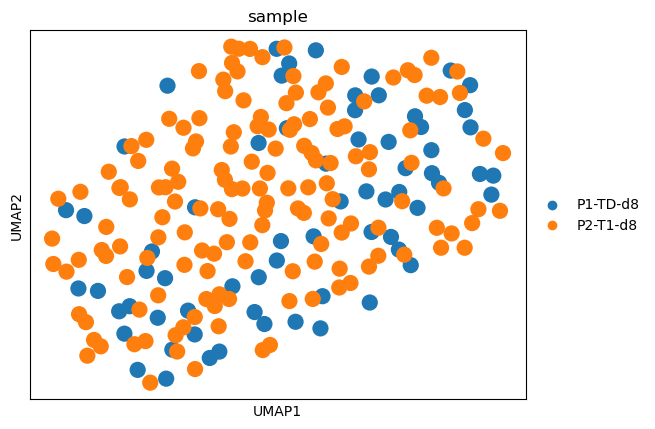

In [100]:
del nk_d8.uns, nk_d8.obsm, nk_d8.varm, nk_d8.obsp
sc.tl.pca(nk_d8, svd_solver='arpack')
sc.pp.neighbors(nk_d8, n_neighbors=10, n_pcs=40)  # using with default parameters
sc.tl.umap(nk_d8)
sc.pl.umap(nk_d8, color='sample')

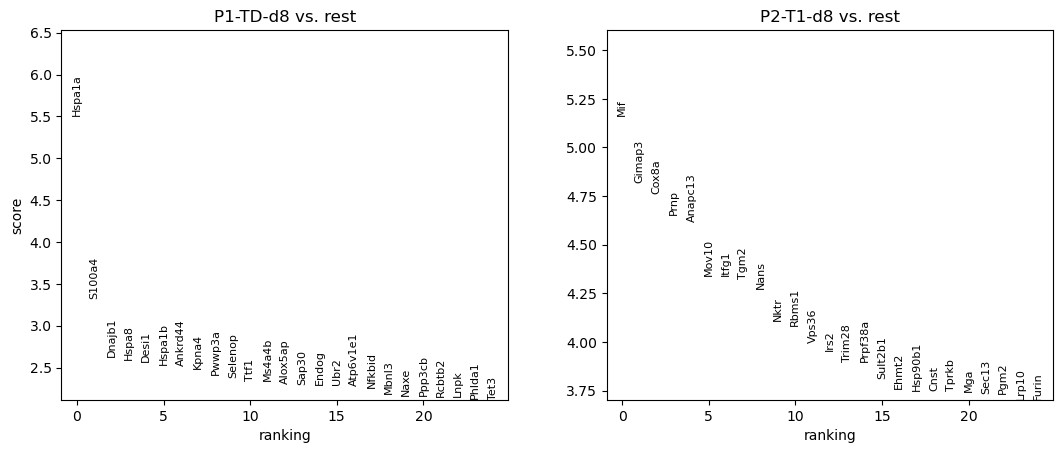

In [101]:
sc.tl.rank_genes_groups(nk_d8, groupby='sample', key_added='nk_d8_DE_results')
nk_d8.uns['nk_d8_DE_results']
sc.pl.rank_genes_groups(nk_d8, n_genes=25, sharey=False, key='nk_d8_DE_results')

In [102]:
file_dir = '/Users/anasuyadighe/Downloads/'
write_deres(file_dir + 'GAP_flex_day8_nk_d8_sample_DEGs.xlsx', nk_d8, 'sample', 'nk_d8_DE_results')

In [104]:
mac.obs

sample  n_genes_by_counts  total_counts  \
AAACCAGGTCATGAAG-1-P1-TD-d8  P1-TD-d8                894        1619.0   
AAACTGGGTATTCGAC-1-P1-TD-d8  P1-TD-d8                573         796.0   
AAACTGTCACAACATG-1-P1-TD-d8  P1-TD-d8                439         553.0   
AAAGATGCAAGAACAA-1-P1-TD-d8  P1-TD-d8                681         990.0   
AAAGTCATCTATCACG-1-P1-TD-d8  P1-TD-d8                479         587.0   
...                               ...                ...           ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8  P2-T1-d8                981        1539.0   
TTTGAGAAGTACCCAC-1-P2-T1-d8  P2-T1-d8               2568        5617.0   
TTTGCGGGTCAAGCTT-1-P2-T1-d8  P2-T1-d8               1437        2490.0   
TTTGGCGGTACTTATG-1-P2-T1-d8  P2-T1-d8                863        1274.0   
TTTGTGAGTCCACAAT-1-P2-T1-d8  P2-T1-d8               1331        2189.0   

                             total_counts_mt  pct_counts_mt  n_counts hashing  \
AAACCAGGTCATGAAG-1-P1-TD-d8              5.0       0.308833    1619.0     1.0   
AAACTGGGTATTCGAC-1-P1-TD-d8              2.0       0.251256     796.0     1.0   
AAACTGTCACAACATG-1-P1-TD-d8              1.0       0.180832     553.0     1.0   
AAAGATGCAAGAACAA-1-P1-TD-d8              5.0       0.505050     990.0     1.0   
AAAGTCATCTATCACG-1-P1-TD-d8              4.0       0.681431     587.0     1.0   
...                                      ...            ...       ...     ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8             27.0       1.754386    1539.0     1.0   
TTTGAGAAGTACCCAC-1-P2-T1-d8             50.0       0.890155    5617.0     1.0   
TTTGCGGGTCAAGCTT-1-P2-T1-d8             14.0       0.562249    2490.0     1.0   
TTTGGCGGTACTTATG-1-P2-T1-d8              0.0       0.000000    1274.0     1.0   
TTTGTGAGTCCACAAT-1-P2-T1-d8              7.0       0.319781    2189.0     1.0   

                            leiden hashtag   CD45 leiden_0.6  leiden_new  \
AAACCAGGTCATGAAG-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAACTGGGTATTCGAC-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAACTGTCACAACATG-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAAGATGCAAGAACAA-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
AAAGTCATCTATCACG-1-P1-TD-d8      1  Hash 1  CD45+          1  Macrophage   
...                            ...     ...    ...        ...         ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8      1  Hash 1  CD45+          4  Macrophage   
TTTGAGAAGTACCCAC-1-P2-T1-d8      1  Hash 1  CD45+          2  Macrophage   
TTTGCGGGTCAAGCTT-1-P2-T1-d8      1  Hash 1  CD45+          4  Macrophage   
TTTGGCGGTACTTATG-1-P2-T1-d8      1  Hash 1  CD45+          1  Macrophage   
TTTGTGAGTCCACAAT-1-P2-T1-d8      1  Hash 1  CD45+          4  Macrophage   

                            replicate  cond_continuous sample_rep  rep_code  \
AAACCAGGTCATGAAG-1-P1-TD-d8        R6                0       0 R6         5   
AAACTGGGTATTCGAC-1-P1-TD-d8        R4                0       0 R4         3   
AAACTGTCACAACATG-1-P1-TD-d8        R1                0       0 R1         0   
AAAGATGCAAGAACAA-1-P1-TD-d8        R3                0       0 R3         2   
AAAGTCATCTATCACG-1-P1-TD-d8        R1                0       0 R1         0   
...                               ...              ...        ...       ...   
TTTGAGAAGGGTTACG-1-P2-T1-d8        R2              100     100 R2         7   
TTTGAGAAGTACCCAC-1-P2-T1-d8        R6              100     100 R6        11   
TTTGCGGGTCAAGCTT-1-P2-T1-d8        R2              100     100 R2         7   
TTTGGCGGTACTTATG-1-P2-T1-d8        R3              100     100 R3         8   
TTTGTGAGTCCACAAT-1-P2-T1-d8        R1              100     100 R1         6   

                             nhood_ixs_random  nhood_ixs_refined  \
AAACCAGGTCATGAAG-1-P1-TD-d8                 0                  0   
AAACTGGGTATTCGAC-1-P1-TD-d8                 1                  1   
AAACTGTCACAACATG-1-P1-TD-d8                 0                  0   
AAAGATGCAAGAACAA-1-P1-TD-d8        

In [105]:
sc.tl.leiden(mac, resolution = 0.6, key_added='leiden_mac')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


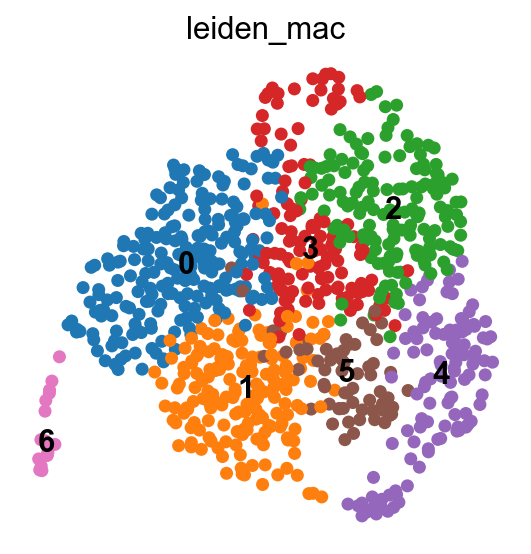

In [134]:
sc.pl.umap(mac, color = 'leiden_mac' , legend_loc = 'on data')

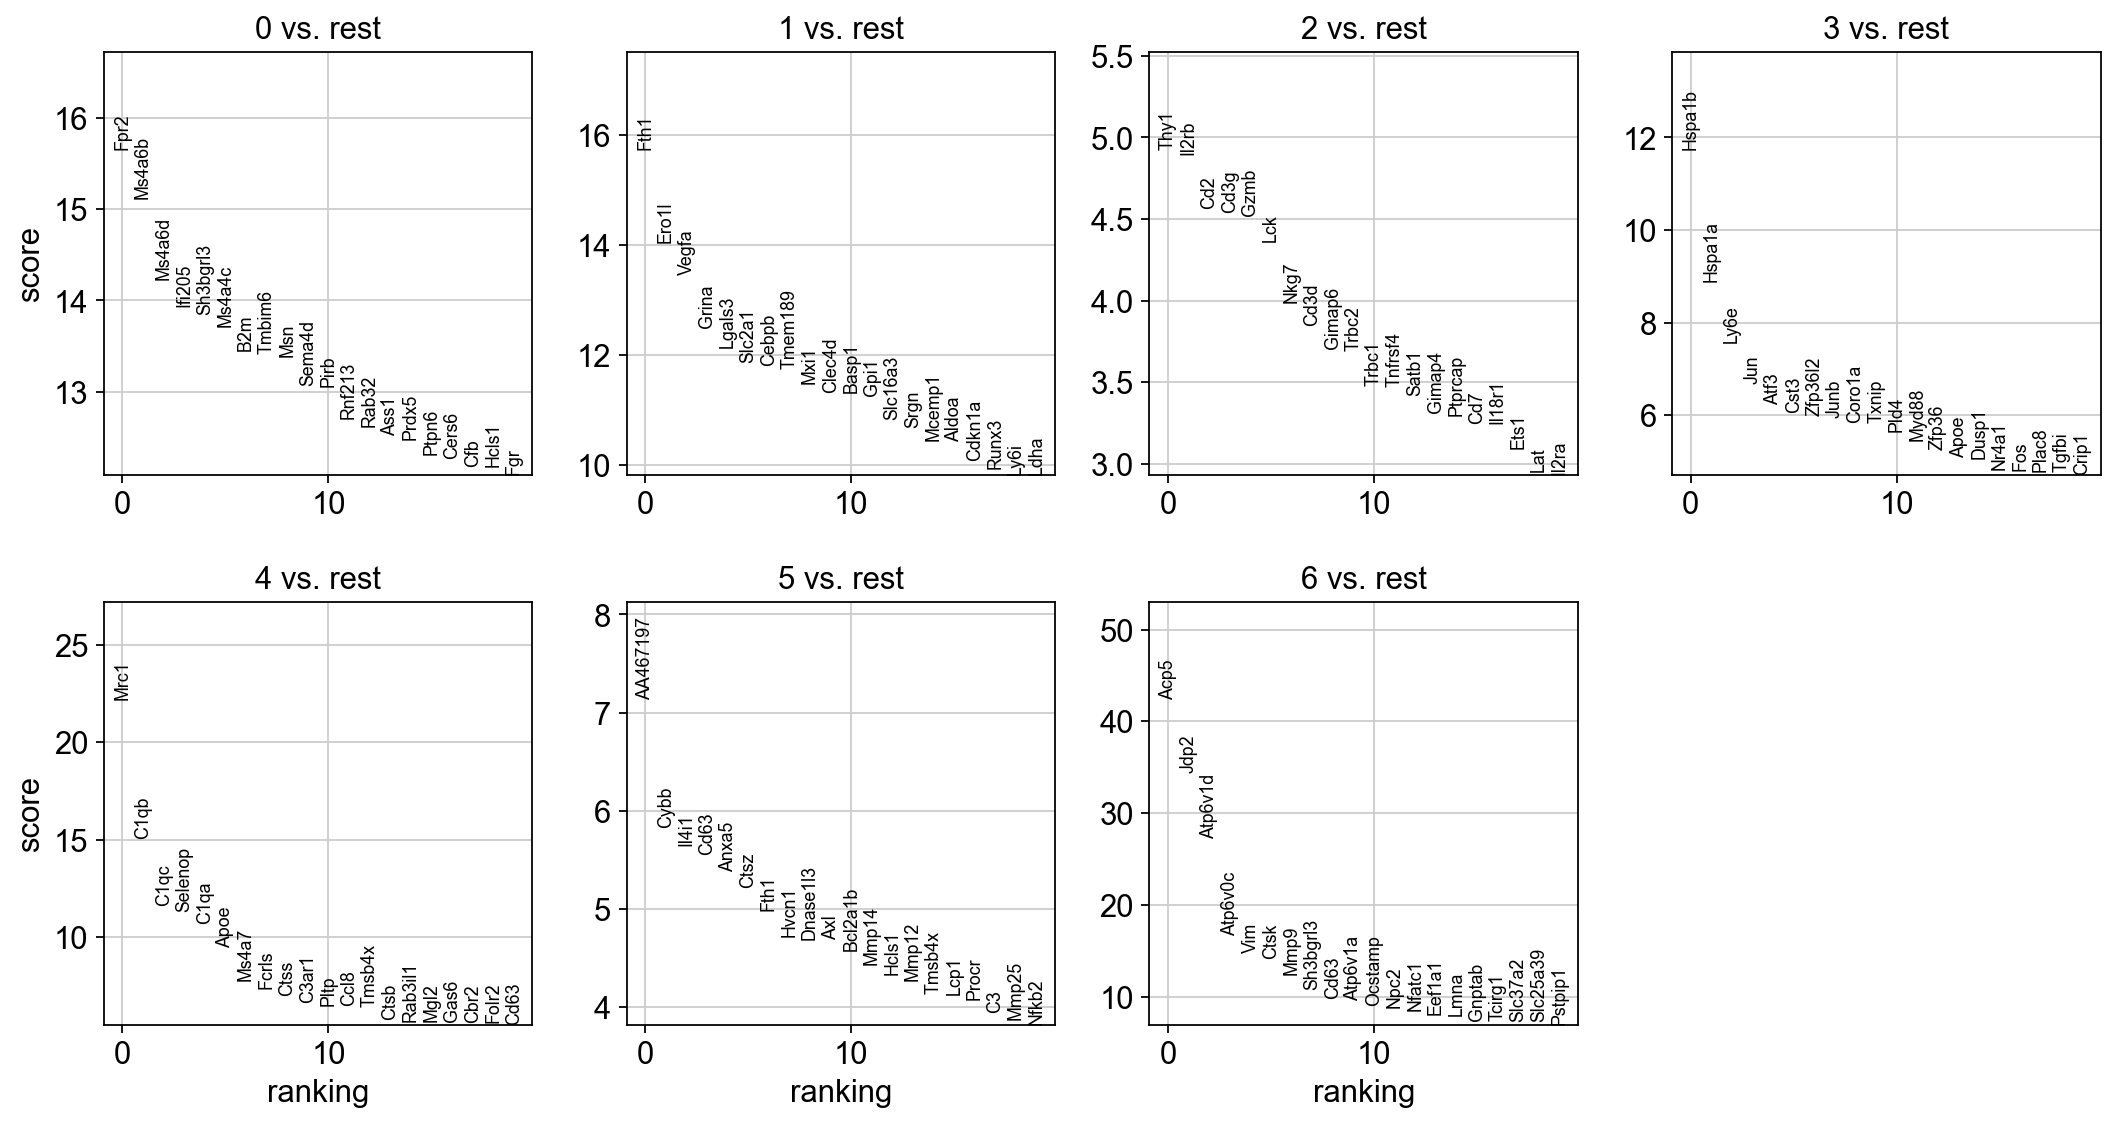

In [109]:
sc.tl.rank_genes_groups(mac, 'leiden_mac', method='t-test')
sc.set_figure_params(frameon=False, figsize=(4, 4))
sc.pl.rank_genes_groups(mac, n_genes=20, sharey=False)

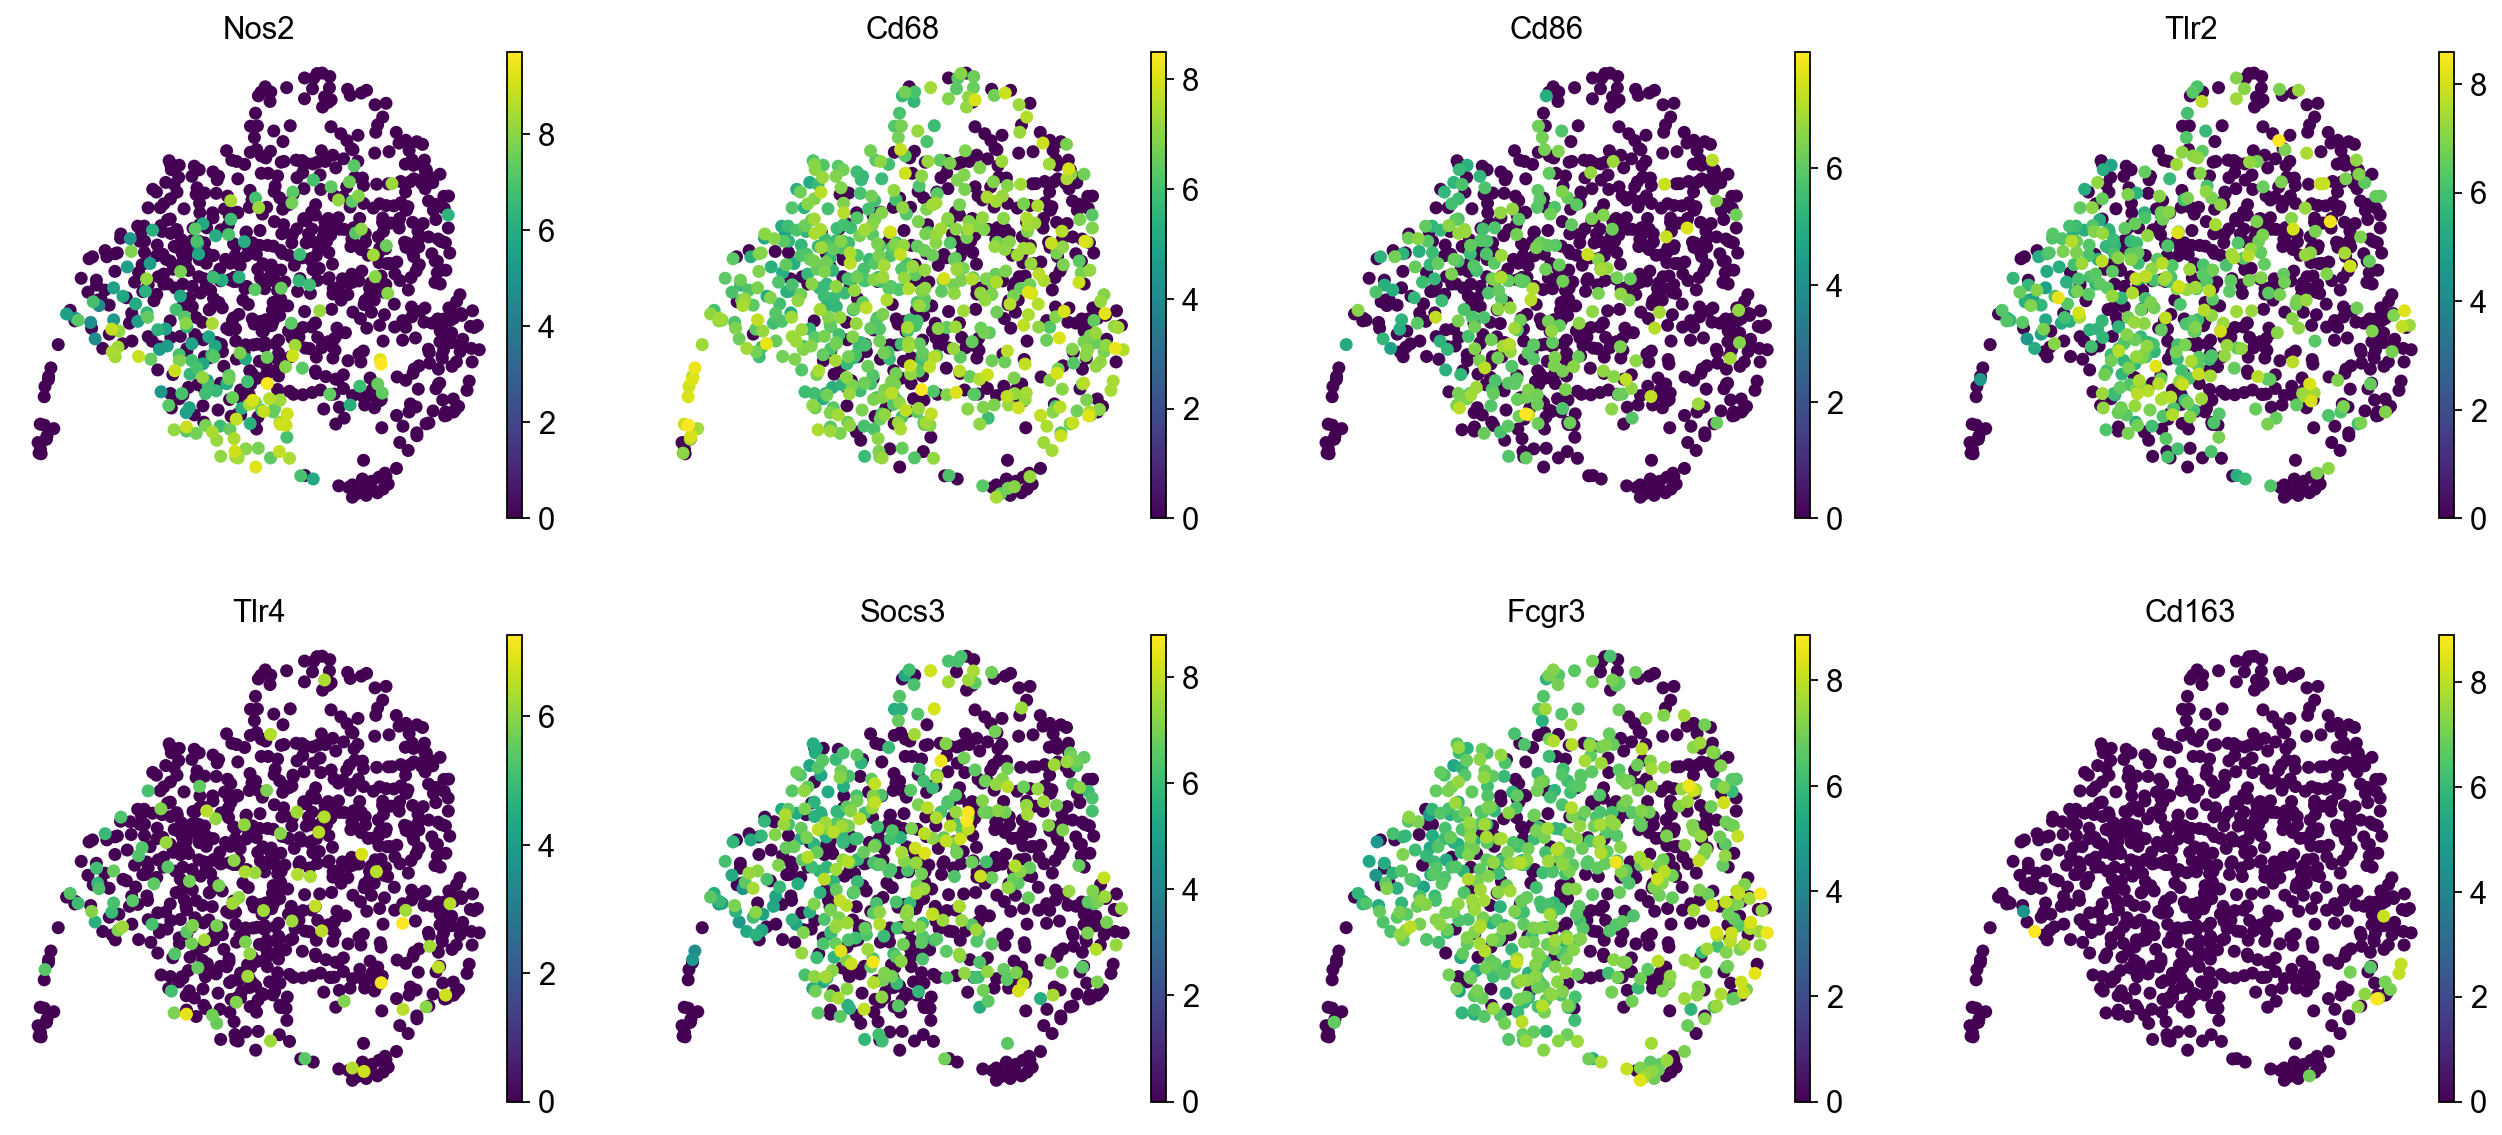

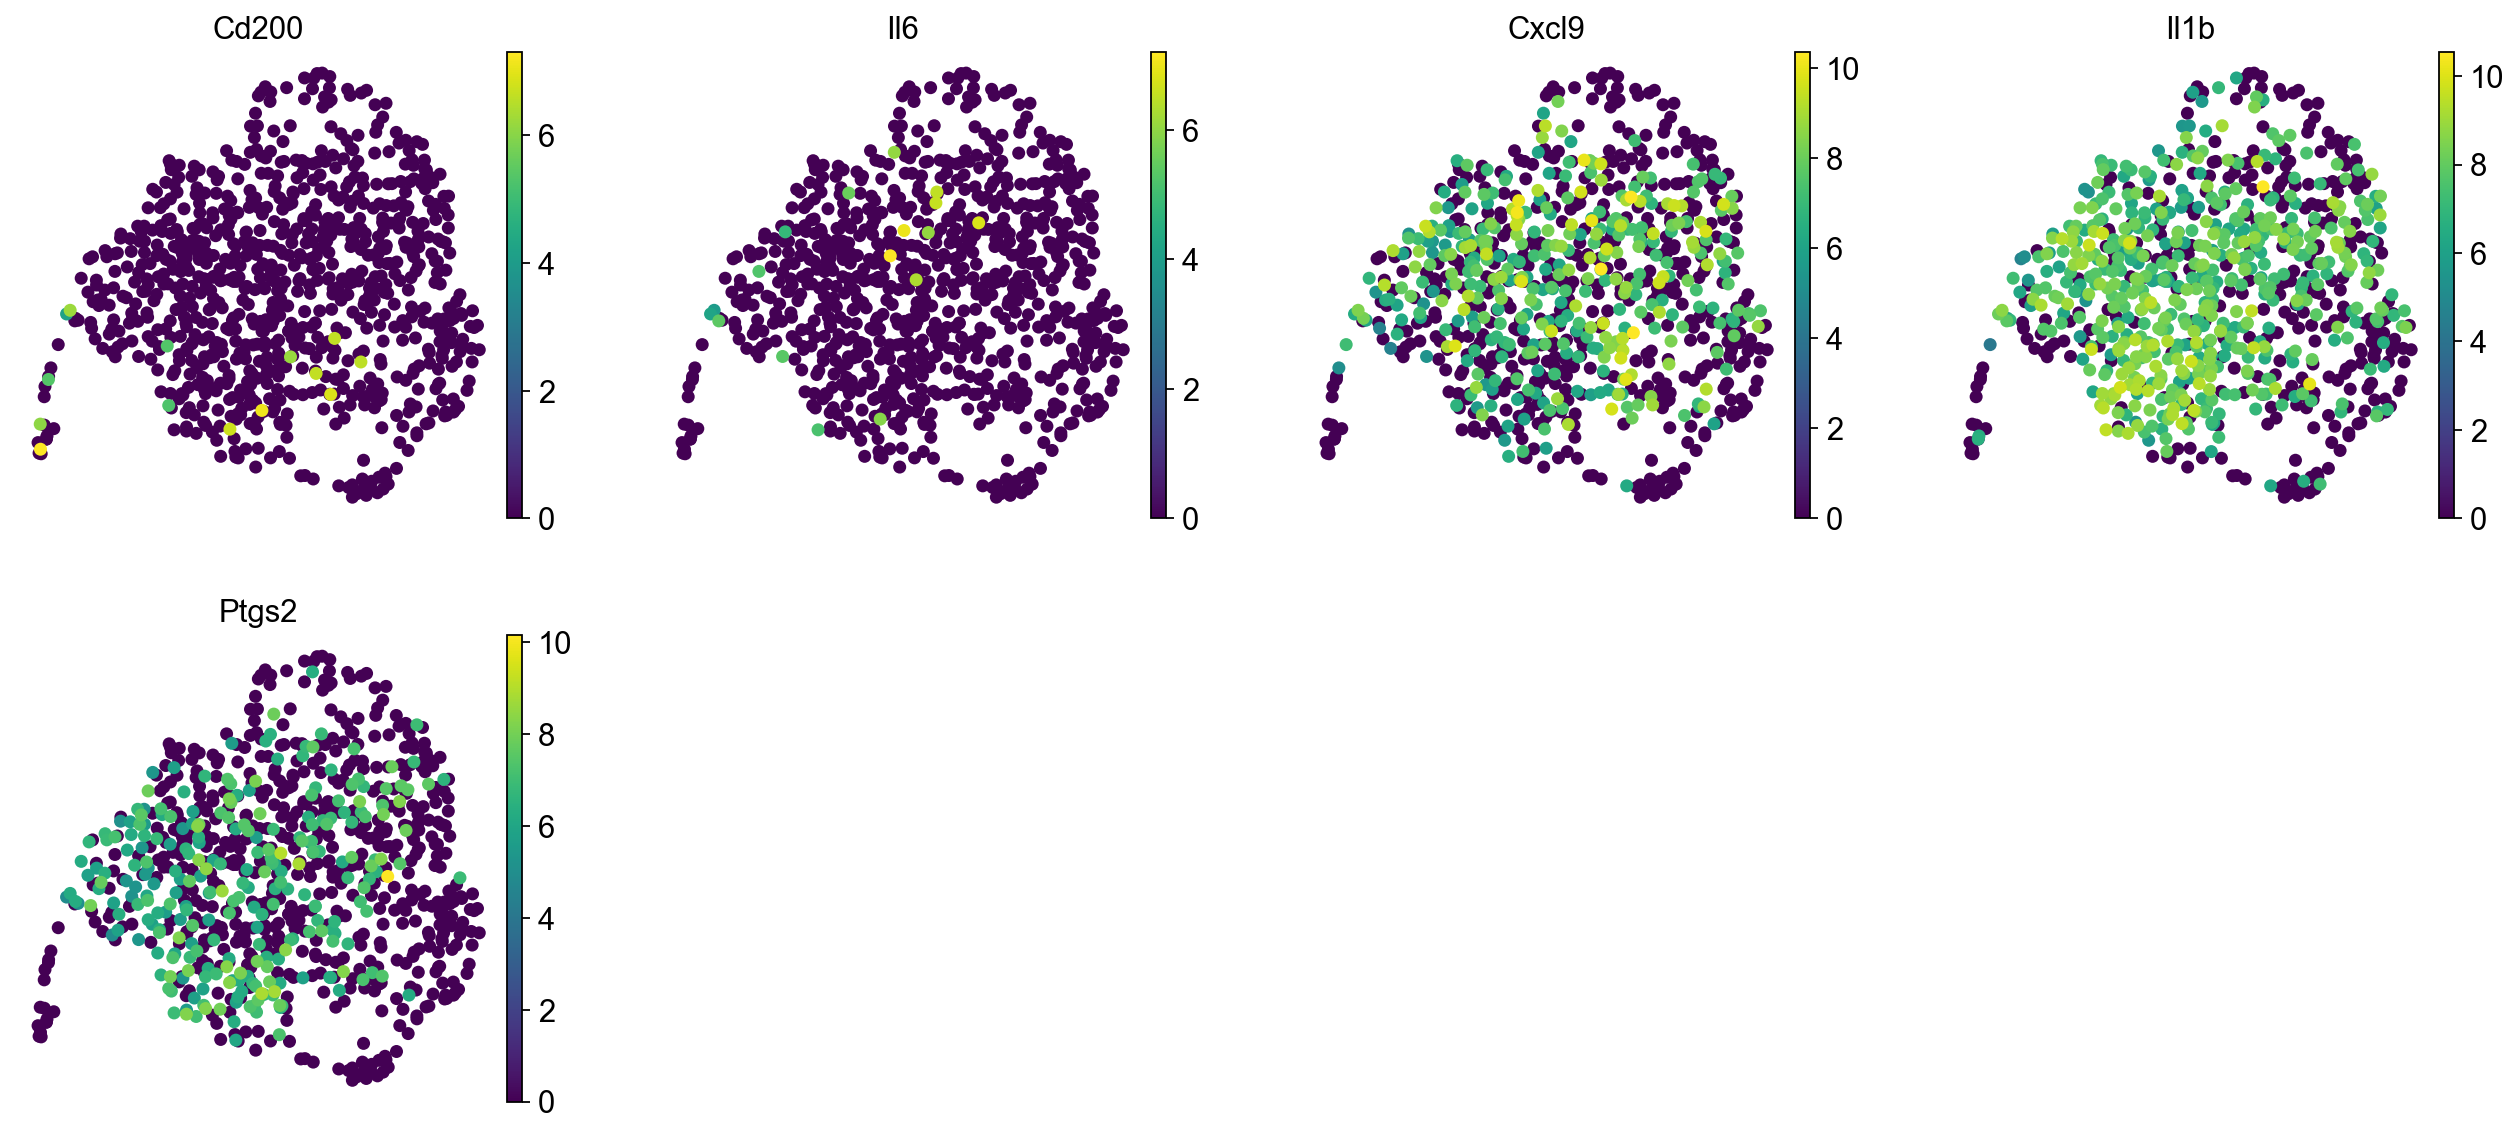

In [144]:
#M1 markers
sc.pl.umap(mac, color= ['Nos2','Cd68','Cd86','Tlr2','Tlr4','Socs3','Fcgr3','Cd163'])
sc.pl.umap(mac, color= ['Cd200','Il6','Cxcl9','Il1b','Ptgs2'])


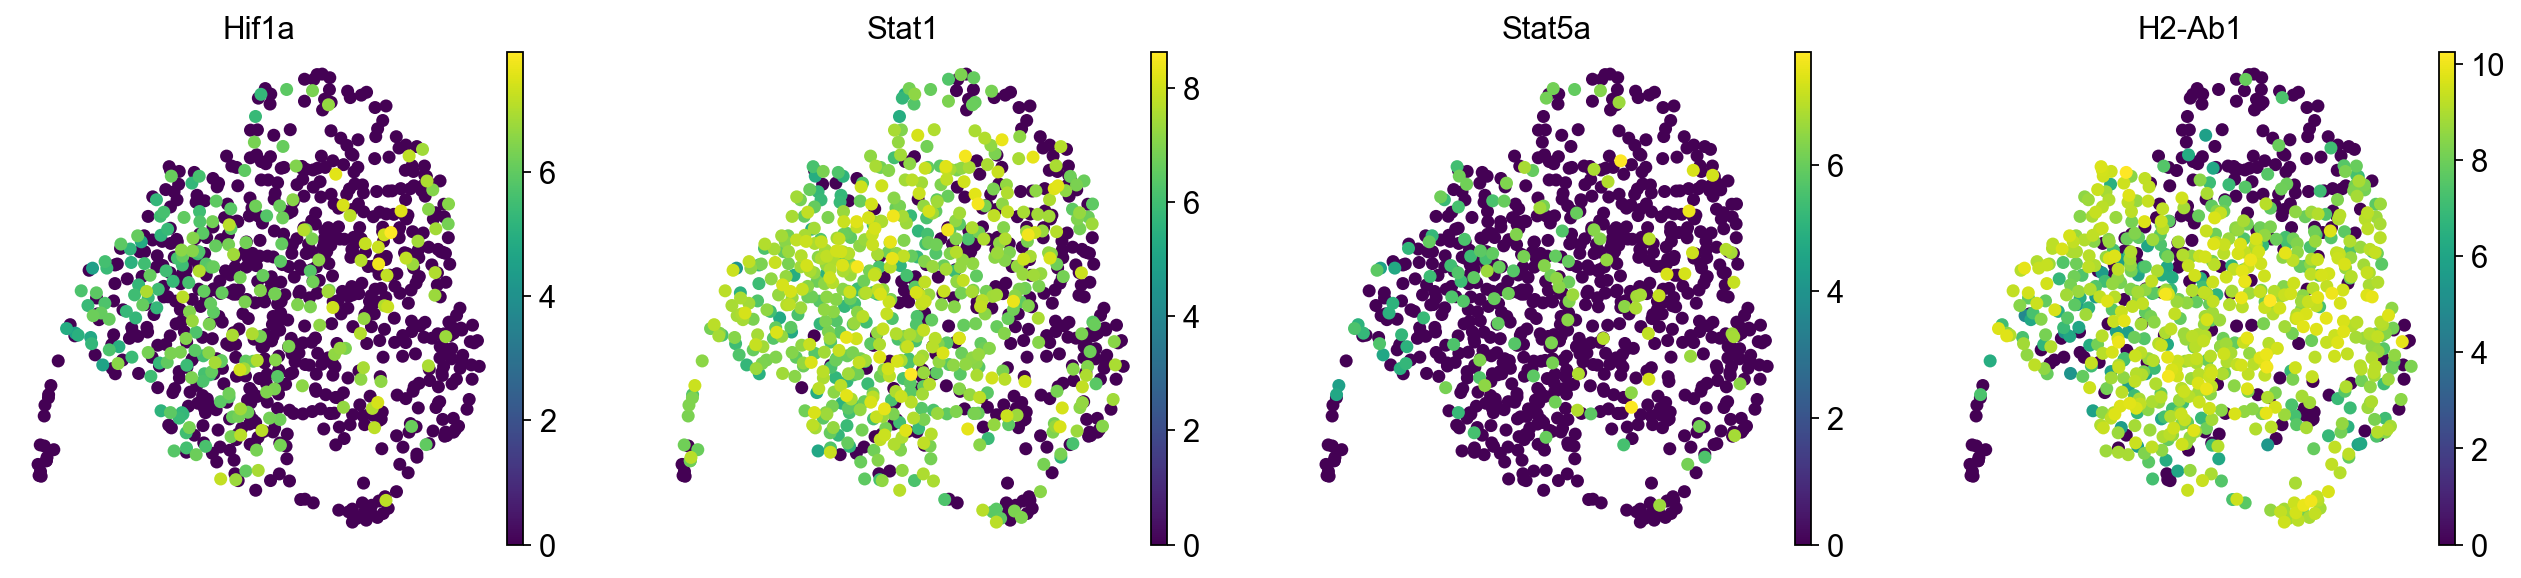

In [133]:
sc.pl.umap(mac, color = ['Hif1a','Stat1','Stat5a','H2-Ab1'])



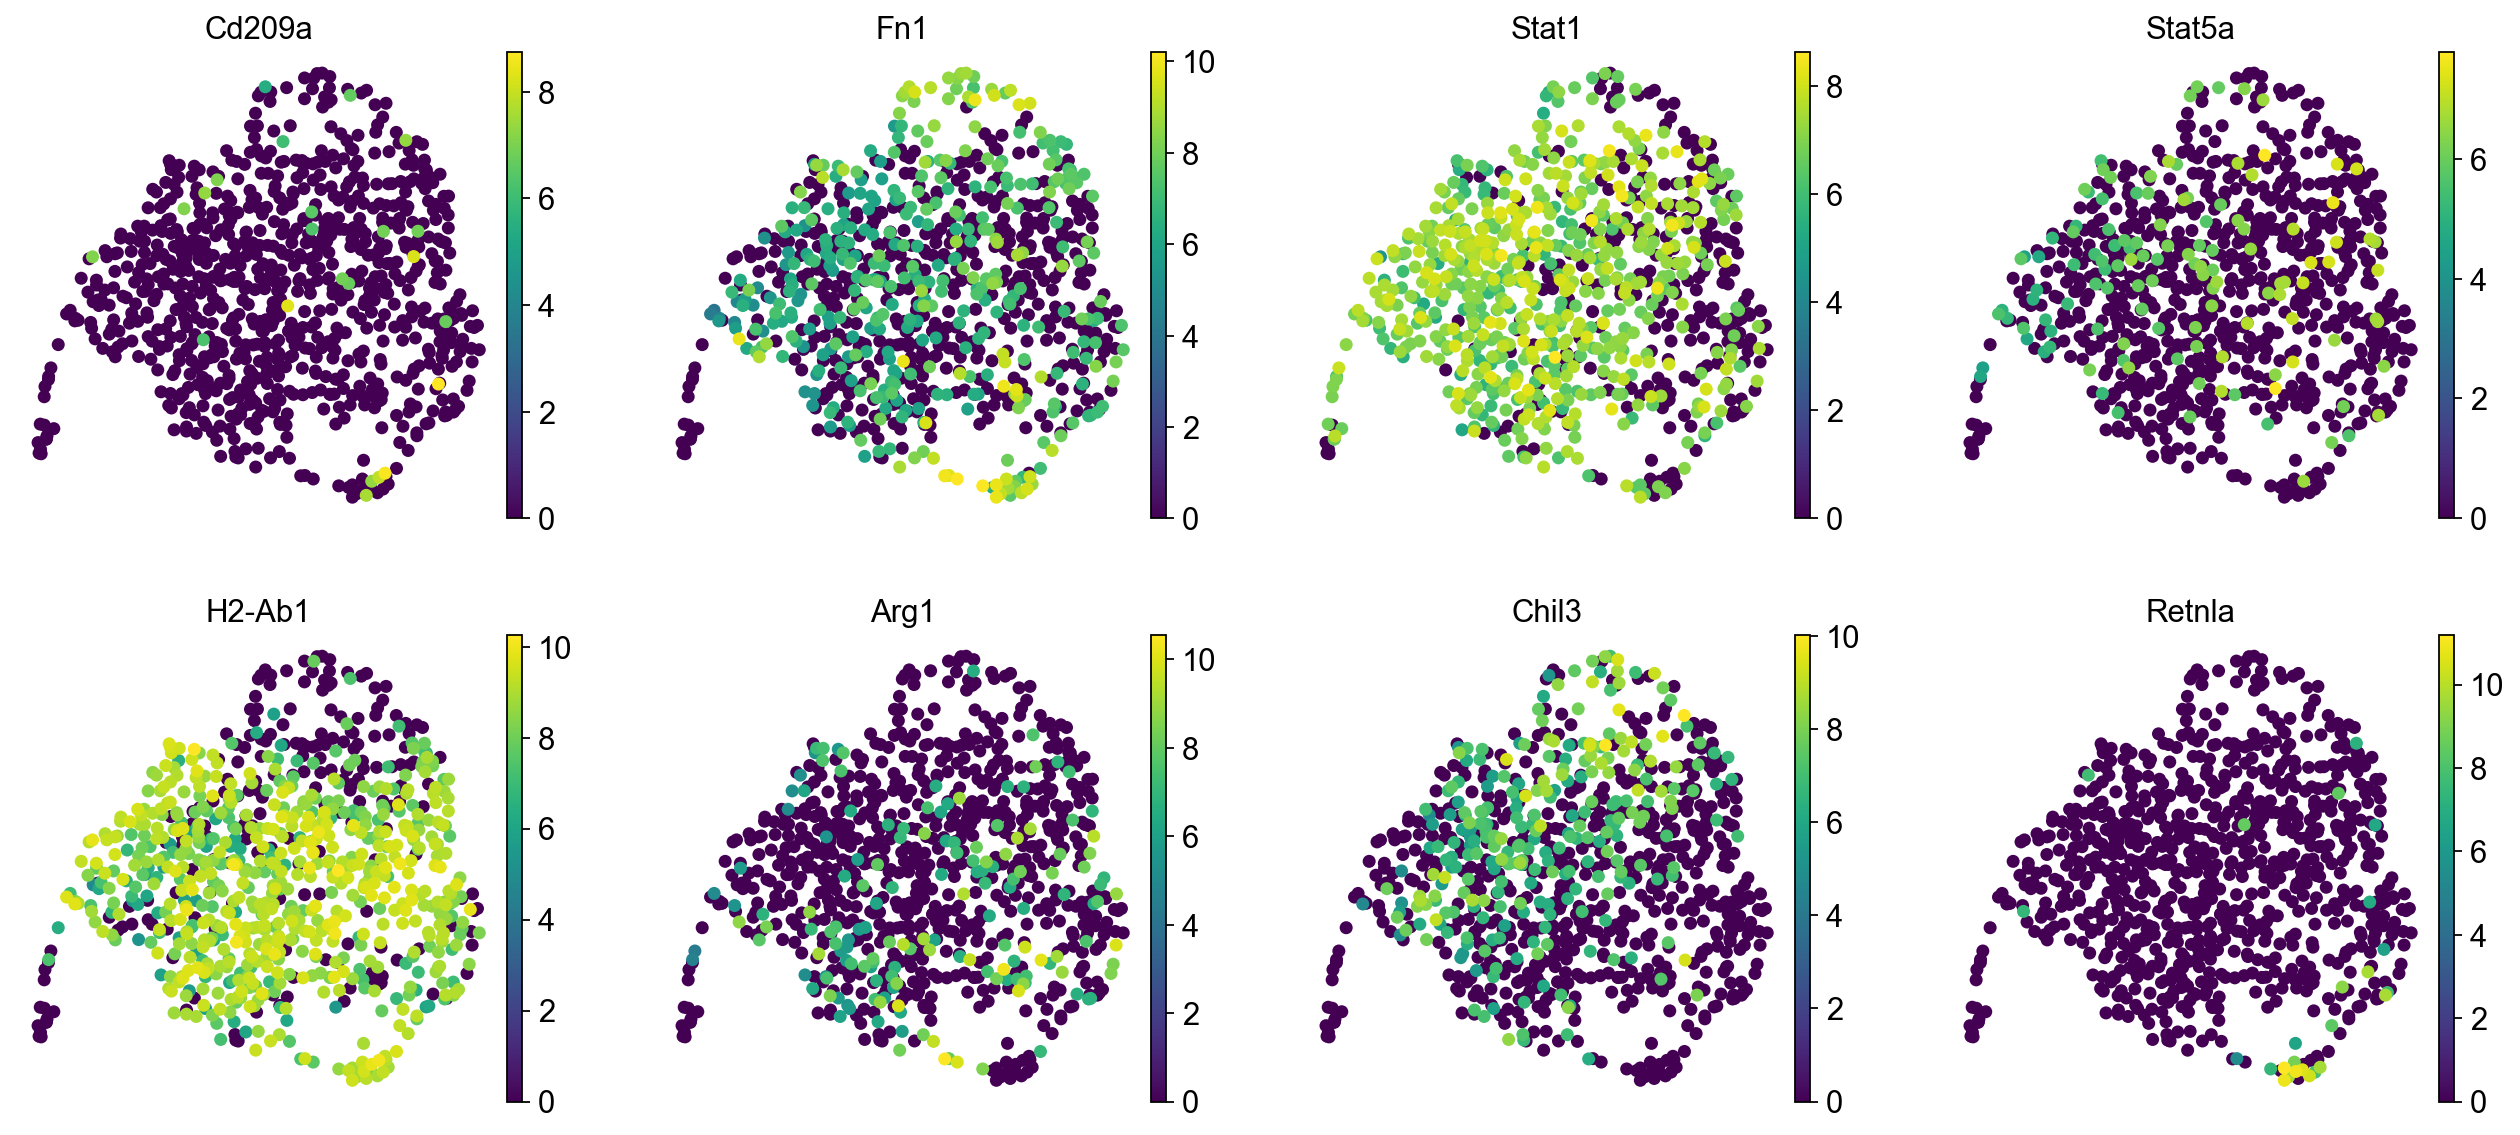

In [153]:
sc.pl.umap(mac, color = ['Cd209a','Fn1','Stat1','Stat5a','H2-Ab1','Arg1','Chil3','Retnla'])

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be igno

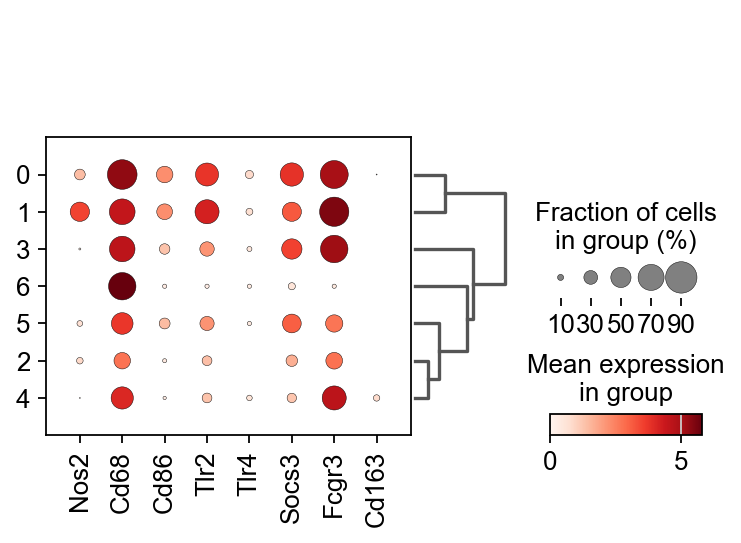

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be igno

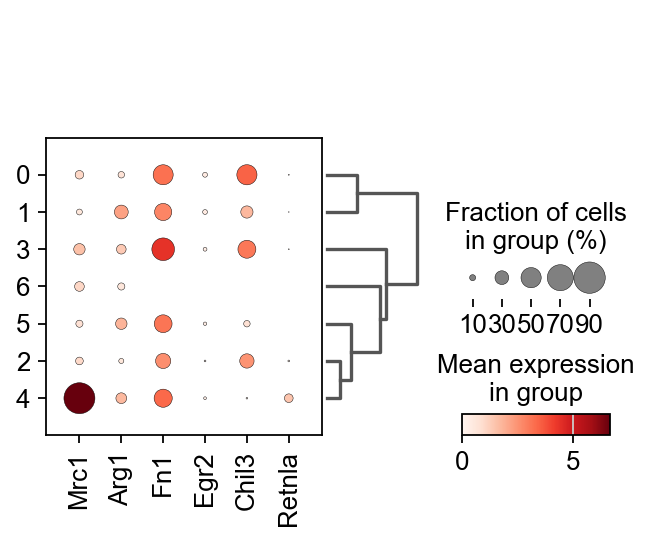

In [150]:
m1markers = ['Nos2','Cd68','Cd86','Tlr2','Tlr4','Socs3','Fcgr3','Cd163']
sc.pl.dotplot(mac, m1markers, groupby='leiden_mac', dendrogram=True)
m2markers = ['Mrc1','Arg1','Fn1','Egr2','Chil3','Retnla']
sc.pl.dotplot(mac, m2markers, groupby='leiden_mac', dendrogram=True)